## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [9]:
import glob
import os
import os.path
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)
    

In [10]:

def BandpassFilter (signal, passband=(40/60, 240/60), fs=125):
    '''Bandpass filter the signal between 40 and 200 BPM"'''
    b, a = sp.signal.butter(3, passband, btype = 'bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

In [15]:
def RunPulseRateAlgorithm(data_fl, ref_fl, fs=125, conf_freq = 5/60, minFreq =(40/60), maxFreq =(240/60) ):
    # Load data using LoadTroikaDataFile and the reference/ground truth data
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ref_data = sp.io.loadmat(ref_fl)['BPM0'].squeeze()

    #Apply bandpass to filter the signals that are out of range
    ppg = BandpassFilter(ppg)
    accx = BandpassFilter(accx)
    accy = BandpassFilter(accy)
    accz = BandpassFilter(accz)
    accmag = np.sqrt(accx**2 + accy**2 + accz**2)
      
    
    #Calculate spectrogram of the signals
    acc_f, _, acc_spec = sp.signal.spectrogram(accmag, fs=fs, nperseg=8*fs, noverlap=6*fs)
    ppg_f, _, ppg_spec = sp.signal.spectrogram(ppg, fs=fs, nperseg=8*fs, noverlap=6*fs)
       

    #keep realistic frequencies / discard the ones outside of the set limits
    valid_idx = (ppg_f >= minFreq) & (ppg_f <= maxFreq)
    ppg_spec[~valid_idx,:] = 0
    

    # Compute pulse rate estimates and estimation confidence.
    errors = []
    confidence = []
    last_ppg_maxf = ppg_f[np.argmax(ppg_spec[:,0])] #We're keeping track of the last estimate for smoothing
    
    for acc_window, ppg_window, target in zip(acc_spec.T, ppg_spec.T, ref_data):
        
        #Find peak/dominant frequencies
        #ACC - peak/dominant frequencies 
        acc_i = np.argmax(acc_window)
        acc_maxf = acc_f[acc_i]
        
        #PPG peak/dominant frequencies
        ppg_k_i = np.argsort(ppg_window)[::-1][:5]
        ppg_k_maxf = ppg_f[ppg_k_i]
        
   
        #Order frequencies by the closest to latest ppg_max frequency 
        new_idx = np.argsort(np.abs(ppg_k_maxf - last_ppg_maxf))
        ppg_k_maxf = ppg_k_maxf[new_idx]
       
        #if the ppg frequency is equal to the acc one select a different one.   
        for i in ppg_k_maxf:
            if acc_maxf == i:
                continue
            else:
                ppg_maxf = i
                break
        
        #Calculate the error 
        est_hr = ppg_maxf * 60
        error = est_hr - target
        errors += [error] #Add the individual error value to the total errors
        
        #Calculate the confidence       
        conf_window = (ppg_f > ppg_maxf - conf_freq) & (ppg_f < ppg_maxf + conf_freq)
        conf = np.sum(ppg_window[conf_window]) / np.sum(ppg_window)
        confidence += [conf] #Add the individual confidence value to the confidence total
        
        #Update last ppg with the maxfreq
        last_ppg_maxf = ppg_maxf
        
         
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.  
    return errors, confidence

In [16]:
Evaluate()

13.043605234432064

### Check dataset for further understanding

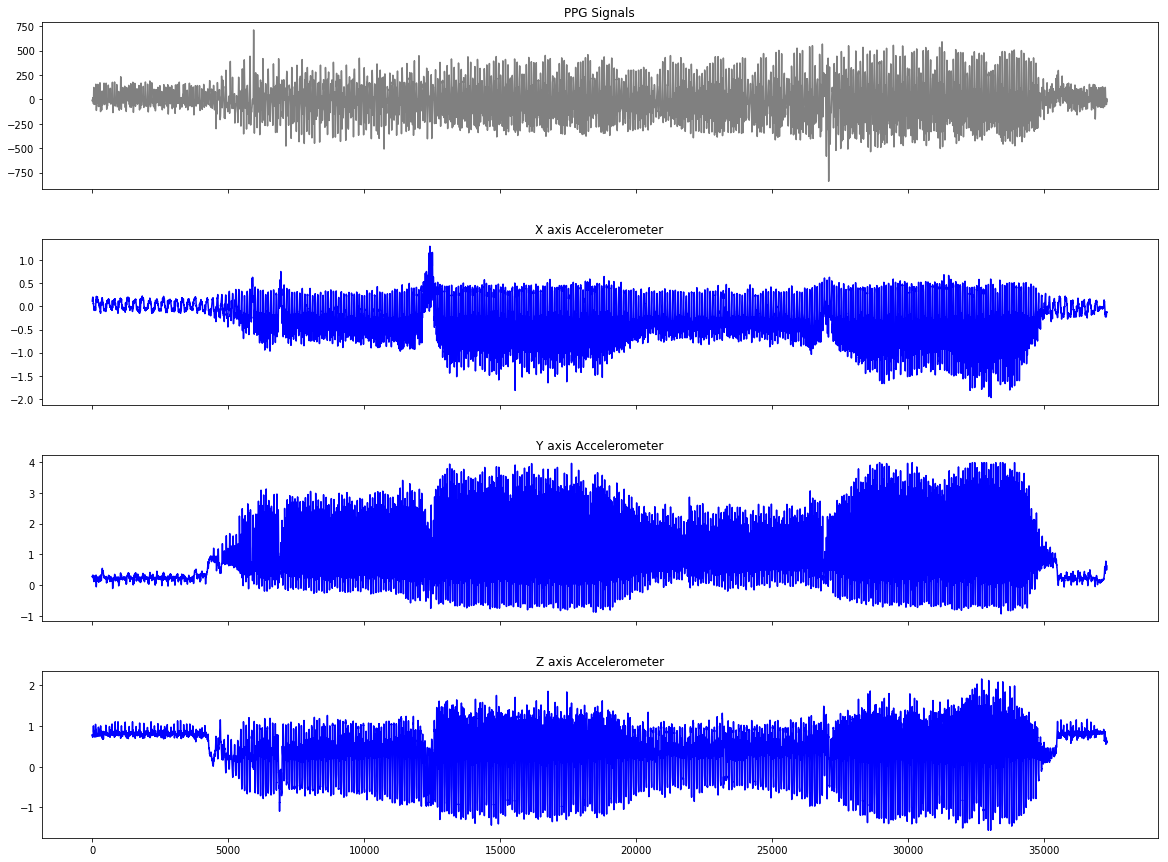

In [5]:
from matplotlib import pyplot as plt

data_fl, ref_fl = LoadTroikaDataset()

file_idx = len(data_fl)-1
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl[file_idx])

fig, ax = plt.subplots(nrows=4, figsize=(20,15), sharex=True)
plt.subplots_adjust(hspace=.3)

ax[0].set_title('PPG Signals')
ax[0].plot(ppg, color='grey')

ax[1].set_title('X axis Accelerometer')
ax[1].plot(accx, color='blue')

ax[2].set_title('Y axis Accelerometer')
ax[2].plot(accy, color='blue')

ax[3].set_title('Z axis Accelerometer')
ax[3].plot(accz, color='blue')

plt.show()

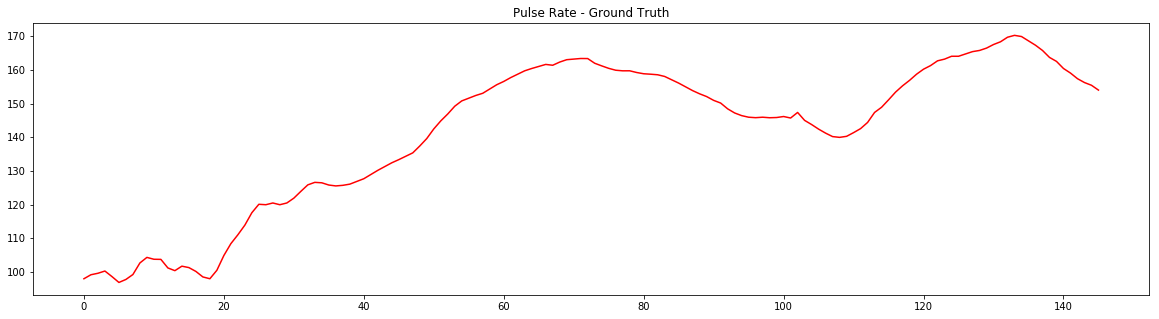

In [6]:
bpm_act = sp.io.loadmat(ref_fl[file_idx])['BPM0']

plt.figure(figsize=(20, 5))
plt.plot(bpm_act, color='red')
plt.title('Pulse Rate - Ground Truth')
plt.show()

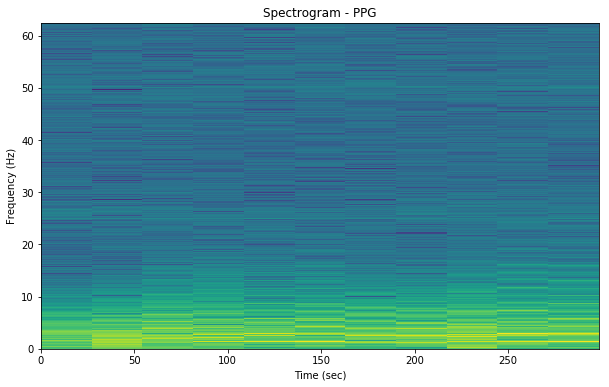

In [7]:
plt.figure(figsize=(10, 6))
plt.title('Spectrogram - PPG')
spec, freqs, t, im = plt.specgram(ppg, Fs=125, NFFT=125*30, noverlap=125*5, xextent=(0, len(ppg)/125))
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)');

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm.
>
> The code loads the PPG data of a 3-axis accelerometer and predicts the pulse rate. The Evaluate function calculates the absolute mean error at 90% availability between the estimated frequency and the ground truth reference.
>
>
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
>
> The data used is a subset of the Troika[1](Reference on top) dataset, which contains data collected for 12 individuals performing different tests/experiments.
>All sampling was done at 125 Hz and the data was obtained by using two-channel wrist PPG signals, 3-axis accelerometer signals and a 1-channel chest ECG.
> The ground truth is also contained within the dataset, labeled as 'BPM0, this data comes from the ECG device.
>
> **Cons/short-comings**: 
> The small sampling of individuals does not provide enough data to make a more robust model, the data set only consists in 12 individuals. 
> The sample does not provide detailed demographics of the individuals, other than their age range (18 to 25 years old), no other data is given (e.g. ethnicity, gender, etc) which makes the data not representative of the real population.
>Also no information is given on the testing conditions in which the subjects were measured, this could also have direct implications on the results. 
>
>
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
>
> The algorithm pre-processes the data, removes all unrealistic frequencies (outside of the range 40BPM & 240BPM), identifies the top strongest PPM signals, compares them with the readings from the accelerometer. 
> Then it calculates the mean absolute error between the calculated frequencies vs the ground truth. 
> 
>**physiology aspects**: The PPG sensor takes advantage of light reflection through the blood flow of the wrist, when the heart pumps blood, whe cells absorb the ligth and the relfection generates a small signal, the signal strengthens when the blood leaves the wrist area. This oscillation can be used to predict the pulse rate. 
>
>**The outputs are**: etsimated frequency of the heartbeats, confidence score and the absolute error rate.
>
>**caveats**: The usage of the peaks from both the ppg and accelerometer the perofmance of the algorithm can be questionable.
>
>
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.
>
> The performance was measured by calculating the Mean Absolute Error (MAE) and the confidence value.
> 
>MAE: 11.3


In [8]:
from IPython.display import Image
Image(url="https://r956022c967580xjupyterwys4whqp.udacity-student-workspaces.com/view/Test%20passed.PNG")

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 